# TDNN for digital pre-distortion

Import modules

In [472]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import csv
from numpy import genfromtxt
import pydot

## Network Config

Enter values for network input size (number of inputs into the TDNN) and the number of desired delays within the TDNN.

The number of inputs will be dependent on the dataset setup. For the PA dataset below there are 2 inputs - real and imaginary parts of the signal

In [473]:
number_of_delays = 4; # This defines the amount of delays that are in the TDNN
number_of_inputs = 2; # The amount of inputs for the nueral network
APSK = False;
QAM = not APSK;

In [474]:
NN_input_size = number_of_inputs*(number_of_delays+1)

Creating the Dataset

In [475]:
if(QAM == True):
    #training data
    real_input = np.genfromtxt('./saleh_real_train_input.csv', delimiter=',')
    real_output = np.genfromtxt('./saleh_real_train_output.csv', delimiter=',')
    imag_input = np.genfromtxt('./saleh_imag_train_input.csv', delimiter=',')
    imag_output = np.genfromtxt('./saleh_imag_train_output.csv', delimiter=',')

    #test data
    real_test_input = np.genfromtxt('./saleh_real_test_input.csv', delimiter=',')
    real_test_output = np.genfromtxt('./saleh_real_test_output.csv', delimiter=',')
    imag_test_input = np.genfromtxt('./saleh_imag_test_input.csv', delimiter=',')
    imag_test_output = np.genfromtxt('./saleh_imag_test_output.csv', delimiter=',')

if (APSK == True):
    #training data
    real_input = np.genfromtxt('./saleh_real_train_input_apsk.csv', delimiter=',')
    real_output = np.genfromtxt('./saleh_real_train_output_apsk.csv', delimiter=',')
    imag_input = np.genfromtxt('./saleh_imag_train_input_apsk.csv', delimiter=',')
    imag_output = np.genfromtxt('./saleh_imag_train_output_apsk.csv', delimiter=',')

    #test data
    real_test_input = np.genfromtxt('./saleh_real_test_input_apsk.csv', delimiter=',')
    real_test_output = np.genfromtxt('./saleh_real_test_output_apsk.csv', delimiter=',')
    imag_test_input = np.genfromtxt('./saleh_imag_test_input_apsk.csv', delimiter=',')
    imag_test_output = np.genfromtxt('./saleh_imag_test_output_apsk.csv', delimiter=',')

Combine real and imaginary parts into a signle input

In [476]:
train_input = np.array([real_input,imag_input])
train_output = np.array([real_output,imag_output])
test_input = np.array([real_test_input,imag_test_input])
test_output = np.array([real_test_output,imag_test_output])

Transpose matrix

In [477]:
train_input = np.transpose(train_input)
train_output = np.transpose(train_output)
test_input = np.transpose(test_input)
test_output = np.transpose(test_output)

Delay function to add addtional columns onto the input, acting as the delays for the TDNN

In [478]:
def delay(X, no_delay):
    """
    This function will expand each row of a given matrix by input no_delay

    Given a Nx2 matrix, and no_delay = 4, the output will be a Nx10

    The additional columns will be based on the previous rows
    n-1, n-2, n-3 and n-4.
    """
    input_samples = X.shape[0]
    input_width = X.shape[1]
    blank_delay = np.zeros(input_width)
    Y = np.empty([input_samples,(input_width*(no_delay+1))])
    for n in range(input_samples):
        delay_array = []
        for i in range(no_delay):
            if((n-(i+1))>=0):
                delay_array = np.append(delay_array, X[n-(i+1)])
            else:
                delay_array = np.append(delay_array,blank_delay)   
        Y[n] = np.r_[X[n],delay_array]

    return(Y)

In [479]:
train_input_delayed = delay(train_input,number_of_delays)
test_input_delayed = delay(test_input,number_of_delays)

### Create the network structure:
The following creates a NN keras strcture and Compiles it and trains it on the dataset

In [513]:
TDNN = keras.Sequential([
    keras.layers.Dense(10,input_shape=(NN_input_size,),activation='sigmoid',kernel_constraint = keras.constraints.MinMaxNorm(-1,1), bias_constraint= keras.constraints.MinMaxNorm(-1,1)),
    keras.layers.Dense(2,activation='linear',kernel_constraint = keras.constraints.MinMaxNorm(-1,1),bias_constraint = keras.constraints.MinMaxNorm(-1,1))
])

TDNN.compile(
    optimizer= keras.optimizers.Adam(),
    loss='mse',
    metrics=['mean_absolute_error', 'accuracy'],
    steps_per_execution= 1
)

TDNN.fit(train_input_delayed,train_output,
        batch_size=32,
        epochs=10,
        validation_split=0.1,
        shuffle = True)

Epoch 1/10
3687/3687 [==============================] - 5s 1ms/step - loss: 0.0220 - mean_absolute_error: 0.0606 - accuracy: 0.9480 - val_loss: 0.0018 - val_mean_absolute_error: 0.0281 - val_accuracy: 0.9494
Epoch 2/10
3687/3687 [==============================] - 4s 1ms/step - loss: 0.0023 - mean_absolute_error: 0.0276 - accuracy: 0.9820 - val_loss: 0.0013 - val_mean_absolute_error: 0.0240 - val_accuracy: 0.9648
Epoch 3/10
3687/3687 [==============================] - 4s 1ms/step - loss: 0.0021 - mean_absolute_error: 0.0269 - accuracy: 0.9799 - val_loss: 0.0015 - val_mean_absolute_error: 0.0274 - val_accuracy: 0.9461
Epoch 4/10
3687/3687 [==============================] - 4s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0266 - accuracy: 0.9797 - val_loss: 0.0014 - val_mean_absolute_error: 0.0270 - val_accuracy: 0.9492
Epoch 5/10
3687/3687 [==============================] - 4s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0265 - accuracy: 0.9796 - val_loss: 0.0014 - val_mean_absolu

Evalutate the system on the test data

In [514]:
TDNN.evaluate(test_input_delayed,test_output)

36450/36450 [==============================] - 34s 931us/step - loss: 0.0418 - mean_absolute_error: 0.1371 - accuracy: 0.9984


[0.04176266863942146, 0.13712984323501587, 0.9983898997306824]

Generate all of the outputs from the test data

In [515]:
Predicted = TDNN.predict(test_input_delayed)
Predicted


36450/36450 [==============================] - 26s 723us/step


array([[-0.30208015,  0.55623484],
       [-0.30253452,  0.5574628 ],
       [-0.28809822,  0.52184594],
       ...,
       [-0.25255996,  0.48147568],
       [-0.25256002,  0.48147568],
       [-0.25256002,  0.48147568]], dtype=float32)

Create a figures to compare the network output and the target output

<Figure size 640x480 with 0 Axes>

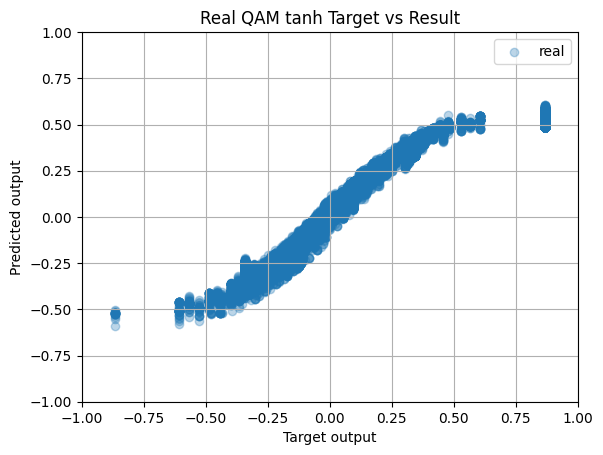

In [517]:
plt.figure()
fig, ax = plt.subplots()
plt.xlabel("Target output")
plt.ylabel("Predicted output")
plt.title('Real QAM tanh Target vs Result')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid()
ax.scatter(test_output[:,0],Predicted[:,0],alpha=0.3,label='real')
ax.legend()

<Figure size 640x480 with 0 Axes>

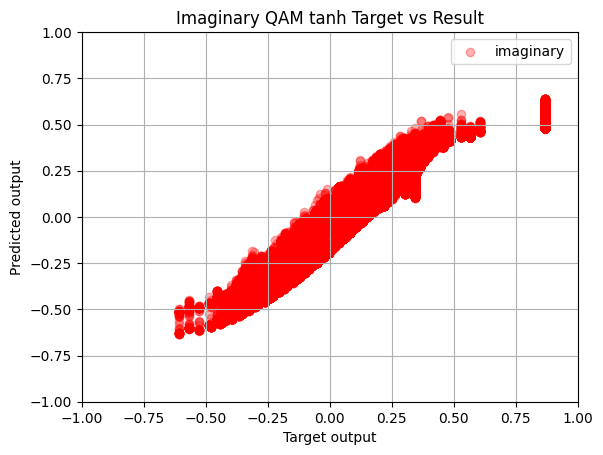

In [518]:
plt.figure()
fig, ax = plt.subplots()
plt.xlabel("Target output")
plt.ylabel("Predicted output")
plt.title('Imaginary QAM tanh Target vs Result')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid()
ax.scatter(test_output[:,1],Predicted[:,1],alpha=0.3,color='red',label='imaginary')
ax.legend()

Display the network structure

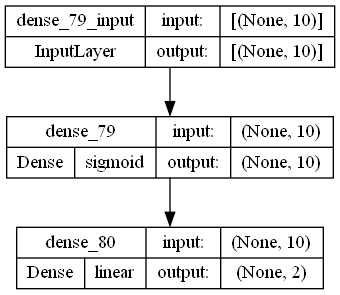

In [519]:
import pydot
from keras.utils.vis_utils import plot_model
plot_model(TDNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

Visualise the network structure

In [520]:
import keras_visualizer as kv

kv.visualizer(TDNN, file_name='visualTDNN', file_format= 'png')

Float to fixed point hex conversion

In [521]:
def float_to_fixed_point(value):
    """
    This function takes in a floating point value
    and converts it to signed 16 bit fixed point hex
    """
    fixed_point = int(value * (2 ** 15 - 1))+1
    if fixed_point < 0:
        fixed_point = (1 << 16) + fixed_point - 2
    elif value == 0:
        fixed_point = 0
    return hex(fixed_point)[2:]

Float to fixed point binary conversion

In [522]:
def float_to_bin_fixed_point(value):
    '''
    This function takes in a floating point value
    and converts it to signed 16 bit fixed point binary
    '''
    fixed_point = int(value * (2 ** 15 - 1)) + 1
    print(fixed_point)
    if fixed_point < 0:
        fixed_point = (1 << 16) + fixed_point - 3
        print(fixed_point)
    return bin(fixed_point)[2:].zfill(16)

### get weights and biases for layer 1

In [523]:
bias = open('bias1.mem', 'w')

for x in np.transpose(TDNN.layers[0].get_weights()[1]):
    data = "{}\n".format(float_to_fixed_point(x)) #string with hex value
    data = data.replace('0x', '') #remove any 0x
    bias.write(data) #write to file

bias.close()

weights = open('weights1.mem', 'w')

for x in np.transpose(TDNN.layers[0].get_weights()[0]):
    for i in x:
        data = "{}\n".format(float_to_fixed_point(i))
        data = data.replace('0x', '')
        weights.write(data)

weights.close()

### get weights and biases for layer 2

In [524]:
#get weights and biases for layer 2
bias = open('bias2.mem', 'w')

for x in np.transpose(TDNN.layers[1].get_weights()[1]):
    data = "{}\n".format(float_to_fixed_point(x)) #string with hex value
    data = data.replace('0x', '') #remove any 0x
    bias.write(data) #write to file

bias.close()

weights = open('weights2.mem', 'w')

for x in np.transpose(TDNN.layers[1].get_weights()[0]):
    for i in x:
        data = "{}\n".format(float_to_fixed_point(i))
        data = data.replace('0x', '')
        weights.write(data)

weights.close()

In [525]:
x = delay(np.array([[0,0],[0,0]]), 4)
TDNN.predict(x)

1/1 [==============================] - 0s 49ms/step


array([[ 0.00821954, -0.00660184],
       [ 0.00821954, -0.00660184]], dtype=float32)

Generate Sigmoid values for the network

In [526]:
#gen sigmoid LUT values
sigmoid_size = 2**20;
#All 16-bit signed fixed point values between -1 and 1
sig_index = range(0,(sigmoid_size)-1)
signed_value = [float(-15)]
for x in sig_index:
    #each subsequent value is a step larger than the last
    signed_value.append(signed_value[-1] + 0.000030517578125)

#sorted from smallest hex value to largest: 0x0 - 0x1fffff
sorted_values = signed_value[491520:] + signed_value[0:491520] 

sig = []
for sfp in sorted_values:
    sig.append(1/(1+np.exp(-sfp)))

sfp = open('sfp.mem', 'w')
for x in sig:
    write_str = "{}\n".format(float_to_fixed_point(x))
    sfp.write(write_str)

sfp.close()

Generate Outputs for the Neural Network to compare with System Verilog Simulation

In [529]:
A = delay(np.array([[-0.55,-0.23],
                    [0.42,0.97],
                    [0.86,-0.34],
                    [-0.99,-0.75],
                    [0.62,-0.12],
                    [0.99,0.86],
                    [-0.39,-0.21],
                    [-0.64,0.77],
                    [0.91,-0.05],
                    [0.12,-0.17]]),
          number_of_delays)



for x in (A):
    print(float_to_fixed_point(x[0]),end=', ')
    print(float_to_fixed_point(x[1]))

TDNN.predict(A)

b99a, e28f
35c3, 7c28
6e14, d47b
8148, a000
4f5c, f0a3
7eb8, 6e14
ce14, e51e
ae15, 628f
747a, f999
f5d, ea3d
1/1 [==============================] - 0s 23ms/step


array([[-0.26952857, -0.00560638],
       [ 0.31524706,  0.3058448 ],
       [ 0.35388988, -0.3003893 ],
       [-0.52772814, -0.14231658],
       [ 0.2799639 , -0.15191057],
       [ 0.53818667,  0.1505712 ],
       [-0.21704316,  0.04910013],
       [-0.16870686,  0.40365633],
       [ 0.38737702, -0.15875062],
       [-0.01071233, -0.10369855]], dtype=float32)